In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '..//')

In [3]:
import pandas as pd

from ev_model.models import controller, bricks, sim_functions
from ev_model.data import enums
from e2slib.analysis import scenario, comparison, site, location
from e2slib.utillib import dummy_data
from ev_model.models import sim_functions, bricks, controller

TARGET_YEAR = 2022


# Generate dummy data

`e2slib` has a useful tool for generating dummy data. We'll use this to create the necessary datasets for our EV Charging simulation. 

Each dataset can be viewed below so your own data can be structured to match in case you'd like to use the tool.

In [4]:
timesteps_array = pd.date_range(start='2022-01-01',
                                end='2022-12-31 23:59',
                                freq='30T',
                                tz='UTC').to_numpy()
import_header = pd.MultiIndex.from_tuples([('peak_site_import_electricity', 'kW')
                                        ])

dummy_site_demand = dummy_data.create_dummy_site_demand(TARGET_YEAR)
dummy_prices = dummy_data.generate_dummy_price_profile(TARGET_YEAR)
dummy_carbon = dummy_data.generate_dummy_carbon_profile(TARGET_YEAR)
dummy_import_lim = pd.DataFrame(index=dummy_site_demand.index,
                                columns=import_header)
dummy_import_lim[import_header] = 150 # Set a uniform import limit of 150kW

/var/folders/f1/6qxrz_6953q6dmnstvb12x540000gn/T/ipykernel_49467/2835705993.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  timesteps_array = pd.date_range(start='2022-01-01',


In [5]:
dummy_site_demand.head()

,Site energy [kWh]
2022-01-01 00:00:00+00:00,10
2022-01-01 00:30:00+00:00,1
2022-01-01 01:00:00+00:00,0
2022-01-01 01:30:00+00:00,4
2022-01-01 02:00:00+00:00,3


In [6]:
dummy_prices.head()

,import_electricity_prices
,GBP/kWh
2022-01-01 00:00:00+00:00,0.14351
2022-01-01 00:30:00+00:00,0.14351
2022-01-01 01:00:00+00:00,0.14351
2022-01-01 01:30:00+00:00,0.14351
2022-01-01 02:00:00+00:00,0.14351


In [7]:
dummy_carbon.head()

,actual
2022-01-01 00:00:00+00:00,180.496376
2022-01-01 00:30:00+00:00,183.712530
2022-01-01 01:00:00+00:00,187.074477
2022-01-01 01:30:00+00:00,190.993198
2022-01-01 02:00:00+00:00,195.627866


# Demo scenario

Now we will use the above dummy data along with our simulated EV charging system to create 3 controlled charging systems optimised for power demand limits, carbon emissions and costs.

## Creating EVs & chargers for optimization

First we need to create our EVs and chargers to create our complete system.

In the cell below we create a list of EV objects using the `sim_functions.create_multiple_EVs()` function which has the following arguments: 
- `nb_evs`: The number of EVs to create.
- `sim_year`: The year we're simulating.
- `list_of_days`: Days of the week that charging will occur. The example below has a standard Mon-Fri business days (Monday = 0, Friday = 4).
- `min_battery_size`: EV battery sizes vary from model to model. The size is measured in kWh, our example is 100kWh minimum.
- `max_battery_size`: EV battery sizes vary from model to model. The size is measured in kWh, our example is 100kWh maximum.

We then set the percentage battery state to set charge amount using `sim_functions.set_fleet_charging_amount()`. In a more advanced simulation you'd more than likely want this to be variable across your different EVs.

We can then create our list of chargers. This can be done using `sim_functions.create_multiple_chargers()` and has the following arguments:
- `list_evs`: The list of EVs we've just created.
- `sim_year`: The year we're simulating.
- `charger_output`: The maximum output of our chargers measured in kW.

This simulates that each charger is connected to a single EV. this mean that if you have a system that has multiple charging ports to a single charger you need to match the `charger_output` to the output of each charging port as if they're individual chargers.

For example, if a 22kW charger has 2 ports and shares this power when 2 vehicles are connected that means that you'd have a `charger_output` of 11kW.

In [8]:
list_evs = sim_functions.create_multiple_EVs(10, TARGET_YEAR, [0, 1, 2, 3],
                                             100, 100)

sim_functions.set_fleet_charging_amount(list_evs, 0.3)

dict_chargers = sim_functions.create_multiple_chargers(list_evs, TARGET_YEAR,
                                                       22)

## Create a basic EV Charging system

Now we can create the EV system object with just the `dict_chargers` and `TARGET_YEAR` values. From here, we can run a default simulation that assumes that every day each EV will need to be charged 30% and they'll be charged as soon as possible without consideration for power import limits.

<Axes: xlabel='TIMESTEP'>

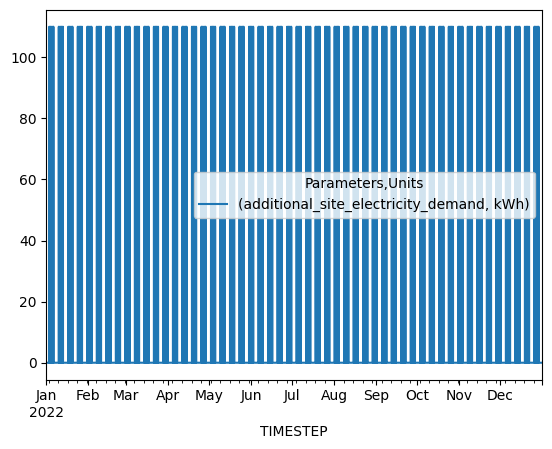

In [9]:
ev_system = sim_functions.create_ev_system(TARGET_YEAR, dict_chargers)

ev_system.run_default_simulation()

ev_system.additional_demand.plot()

#### Example of the charging profile

We can view how the EVs are charging by accessing the `.get_recorded_data_from_evs()` function for the charger object, an example is shown below highlighting a few things.
1. The EVs are plugged in Monday to Friday between 9 and 5.
2. The energy input for a basic optimisation starts as soon as the EV is plugged in and ends after the first timestep. This is due to the EV being fully charged within this period.

<Axes: xlabel='TIMESTEP'>

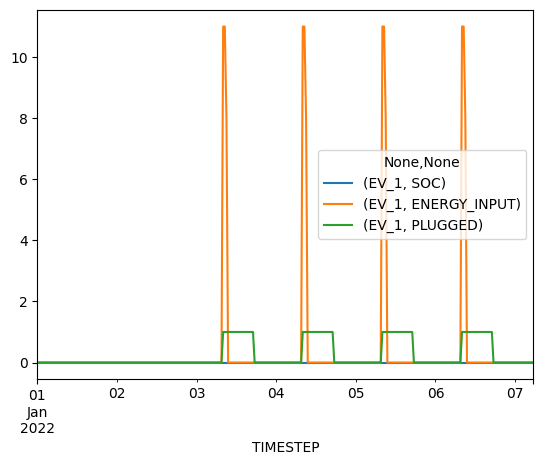

In [10]:
dict_chargers['Charger_1'].get_recorded_data_from_evs().head(300).plot()

# Optimising charging

Now we can generate an optimized site using `controller.Optimized_Sites()`. This takes all the variables we've already created:
- `timesteps`: A numpy array of half-hourly datetime values for the simulation period
- `site_electricity_demand`: Your site energy consumption data, our `dummy_site_demand`.
- `carbon_dataf`: Our carbon intensity data, this can be found online for your region.
- `price_dataf`: The price profile for your energy consumption.
- `dict_of_chargers`: The dictionary of chargers, as created above.
- `site_data_recorder`: A site `bricks.TimeseriesRecorder()` object.
- `max_import_demand`: The sites import demand limit as found on your sites energy bills. This maybe uniform at all times or maybe variable.

All control optimizers can now be executed using `Optimized_Sites.run_all_control_methods()` which generates a dictionary of each controlled site type, they're named `Basic`, `Emission` and `Price` to represent each different control method currently in use. 

In [39]:
site_data_recorder = bricks.TimeserieRecorder(dummy_site_demand.index,
                                              list(enums.SiteData))

test_optimizer = controller.Optimized_Sites(timesteps=timesteps_array, site_electricity_demand=dummy_site_demand,
                                            carbon_dataf = dummy_carbon, price_dataf=dummy_prices,
                                            dict_of_chargers = dict_chargers, site_data_recorder = site_data_recorder,
                                            max_import_demand = dummy_import_lim)
dict_of_sites = test_optimizer.run_all_control_methods()

The site demand is 208905 kWh and max import 80.0 kW
The site demand is 208905 kWh and max import 80.0 kW
The site demand is 208905 kWh and max import 80.0 kW
PV_OPTIMIZER could not be executed as profile was not supplied.


### Example charging profile from the price optimisation.

As you can see in the cell below on both days charging stops when costs increase. It then starts again after the price of energy drops again.

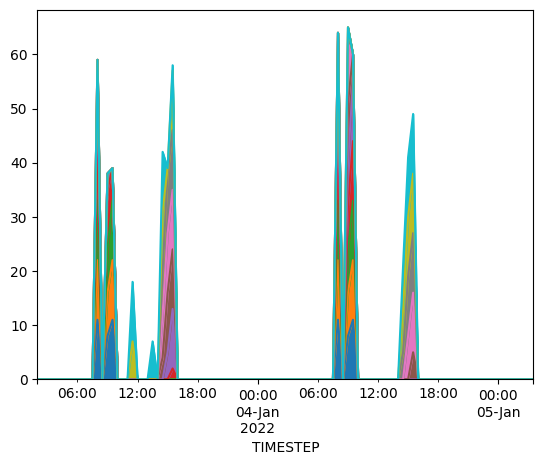

In [40]:
ax = dict_of_sites['Price'].get_recorded_data_from_chargers().iloc[100:200].plot(kind="area", stacked=True)
ax.legend().remove()

# Scenario Comparison

We can now use `e2slib.scenario.Senario()` to compare our differently optimised systems. Each system is loaded into its own individual scenario obj with the price, carbon and a `site.Site()` object which contains the location object, assets and site demand.

We can then use the `e2slib.comparison.ScenarioComparison()` object to compare the different optimised systems against the current system which doesn't have EV. By doing so we can see how different optimisations effect energy costs and emissions. You can also see things such as the capital cost of the installation, peak site demand changes and the annual additional energy demands due to the EV system.

In [41]:
hh_location: location.GeoLocation = location.GeoLocation(
    name='Test Site',
    latitude=51.555371,
    longitude=-1.441886,
    altitude=10,
    timezone='UTC')

site_data_recorder = bricks.TimeserieRecorder(dummy_site_demand.index,
                                              list(enums.SiteData))
dict_assets = {}

list_assets = [
    [], [dict_of_sites['Basic']], [dict_of_sites['Emission']],
    [dict_of_sites['Price']]
]
list_scenario_names = ["Current system", "Basic optimisation", "Emission optimisation", "Price optimisation"]
list_scenarios = []
for ii, temp_assets in enumerate(list_assets):
  temp_name = list_scenario_names[ii]
  temp_model = site.Site(temp_name, hh_location, temp_assets,
                         dummy_site_demand)
  site_energy_demand = temp_model.export_results()
  print(temp_name)
  temp_scenario = scenario.Scenario(temp_name,
                                    temp_model,
                                    import_electricity_prices=dummy_prices,
                                    import_electricity_emission_factor=dummy_carbon,
                                    export_electricity_prices=pd.DataFrame())
  list_scenarios.append(temp_scenario)
ref_scenario = list_scenarios[0]
comparison_scenarios = comparison.ScenarioComparison(ref_scenario, list_scenarios)

comparison_scenarios.summary_results.round(0)

The results will be stored at:
/Users/rhysjones/Library/CloudStorage/GoogleDrive-rhys.jones@e2s.energy/My Drive/ev
Current system
The results will be stored at:
/Users/rhysjones/Library/CloudStorage/GoogleDrive-rhys.jones@e2s.energy/My Drive/ev
Basic optimisation
The results will be stored at:
/Users/rhysjones/Library/CloudStorage/GoogleDrive-rhys.jones@e2s.energy/My Drive/ev
Emission optimisation
The results will be stored at:
/Users/rhysjones/Library/CloudStorage/GoogleDrive-rhys.jones@e2s.energy/My Drive/ev
Price optimisation


,,Basic optimisation,Current system,Emission optimisation,Price optimisation
Parameters,Units,,,,
site_import_electricity_demand,kWh,271299.0,208905.0,271299.0,271299.0
site_export_electricity_demand,kWh,0.0,0.0,0.0,0.0
electricity_generation,kWh,0.0,0.0,0.0,0.0
additional_site_electricity_demand,kWh,62394.0,0.0,62394.0,62394.0
initial_site_electricity_demand,kWh,208905.0,208905.0,208905.0,208905.0
self-consumed_electricity,kWh,0.0,0.0,0.0,0.0
import_electricity_costs,GBP,54981.0,42491.0,55480.0,54981.0
export_electricity_revenues,GBP,-0.0,-0.0,-0.0,-0.0
import_electricity_savings,GBP,0.0,0.0,0.0,0.0
